In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os

path2add = os.path.normpath(os.path.abspath('..'))
print(path2add)
if not (path2add in sys.path) :
    sys.path.append(path2add)


import torch
from torch_geometric.data import Data
from dataloader import GraphDataset, GraphTextDataset, TextDataset, GraphTextInMDataset, AllGraphDataset, AugmentGraphDataset
from augment import RWSample, UniformSample
import networkx as nx

from transformers import AutoTokenizer

c:\Antoine\Study\Master 2 - MVA\ALTEGRAD\Altegrad-MVA-2023-2024


In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
tokenizer = AutoTokenizer.from_pretrained('nlpie/distil-biobert')#'microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext')

In [ ]:
import os
import shutil
from tqdm import tqdm

source_directory = r"C:\Antoine\Study\Master 2 - MVA\ALTEGRAD\Challenge\Public\Public\data"
destination_directory = r"C:\Antoine\Study\Master 2 - MVA\ALTEGRAD\Altegrad-MVA-2023-2024\data"

def move_files(source_directory, destination_directory):
    # Make sure the destination directory exists, create it if not
    if not os.path.exists(destination_directory):
        os.makedirs(destination_directory)

    # Get the total number of files to track progress
    total_files = sum([len(files) for _, _, files in os.walk(source_directory)])

    # Initialize the tqdm progress bar
    progress_bar = tqdm(total=total_files, desc="Moving files", unit="file")

    # Walk through the source directory and its subdirectories
    for root, _, files in os.walk(source_directory):
        for file_name in files:
            source_path = os.path.join(root, file_name)
            # Create the corresponding subdirectory structure in the destination
            relative_path = os.path.relpath(source_path, source_directory)
            destination_path = os.path.join(destination_directory, relative_path)

            destination_dir = os.path.dirname(destination_path)
            if not os.path.exists(destination_dir):
                os.makedirs(destination_dir)


            # Move the file
            shutil.move(source_path, destination_path)

            # Update the progress bar
            progress_bar.update(1)

    # Close the progress bar
    progress_bar.close()

In [5]:
import textwrap

In [6]:
def show_sample(sample):
    edges = sample.edge_index
    G = nx.DiGraph()

    # Add edges to the graph
    for i in range(len(edges[0])):
        G.add_edge(int(edges[0][i]), int(edges[1][i]))

    # Draw the graph
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos, with_labels=True, font_size=8, node_color='skyblue', node_size=200, edge_color='gray', linewidths=0.3, arrows=False)

    # Show the plot
    decoded_input = tokenizer.batch_decode(sample.input_ids, skip_special_tokens=True)[0]
    wrapped_text = textwrap.fill(decoded_input, width=70)

    print(sample.edge_index)

    plt.text(0, -1, wrapped_text, ha='center', va='center', fontsize=8, bbox=dict(facecolor='white', alpha=0.4))

In [ ]:
# move_files(source_directory, destination_directory)

In [18]:
train_dir = r"data/processed_nlpie/train/"
test_dir = r"data/processed_nlpie/test/"

In [ ]:
sample = torch.load(train_dir + "data.pt")

In [49]:
rnd = [0, 0]
for i in range(100000):
    rnd[np.random.randint(2)] += 1

print(rnd)

[49897, 50103]


In [103]:
transforms = [RWSample(), UniformSample()]

def transform_augment(sample):
    tmp = sample.clone()
    if tmp.x.shape[0] > 6:
        # Randomly select a transformation without using np.random.choice
        choice = np.random.randint(2)
        transform = transforms[choice]
        tmp = transform(tmp)

    if len(sample.description) == 1:
        print("Repeating description")
        print(sample.description)
        sample.description = [sample.description[0], sample.description[0]]
        print(sample.input_ids)

    data = Data(
        x = sample.x,
        edge_index = sample.edge_index,

        x_augment = tmp.x,
        edge_index_augment = tmp.edge_index,

        input_ids = sample.input_ids,
        attention_mask = sample.attention_mask,

        description = sample.description,
    )
    return data

In [104]:
def load_datasets(tokenizer: AutoTokenizer):
    gt = np.load("../data/token_embedding_dict.npy", allow_pickle=True)[()]
    val_dataset = GraphTextInMDataset(
        root="../data/", gt=gt, split="val", tokenizer=tokenizer, model_name='nlpie/distil-biobert'
    )
    train_dataset = GraphTextInMDataset(
        root="../data/", gt=gt, split="train", tokenizer=tokenizer, model_name='nlpie/distil-biobert', transform=transform_augment
    )
    return val_dataset, train_dataset

val_dataset, train_dataset = load_datasets(tokenizer)

In [105]:
sample = train_dataset[4251]
sample

Data(x=[31, 300], edge_index=[2, 66], x_augment=[27, 300], edge_index_augment=[2, 50], input_ids=[2, 256], attention_mask=[2, 256], description=[2])

In [109]:
sample = train_dataset[4411]
sample.description, tokenizer.batch_decode(sample.input_ids, skip_special_tokens=True)

(['Rhinacanthin C is a naphthoquinone isolated from Rhinacanthus nasutus and has been shown to exhibit antiviral activity. It has a role as a metabolite, an antiviral agent and an antineoplastic agent',
  'It is a carboxylic ester, an enol, an enoate ester and a hydroxy-1,4-naphthoquinone.'],
 ['Rhinacanthin C is a naphthoquinone isolated from Rhinacanthus nasutus and has been shown to exhibit antiviral activity. It has a role as a metabolite, an antiviral agent and an antineoplastic agent',
  'It is a carboxylic ester, an enol, an enoate ester and a hydroxy - 1, 4 - naphthoquinone.'])

In [99]:
from torch_geometric.loader import DataLoader

batch_size = 128
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [100]:
next(iter(train_loader))

Repeating description
['Alpha-maltotetraose is a maltotetraose tetrasaccharide in which the glucose residue at the reducing end is in the pyranose ring form and has alpha configuration at the anomeric carbon atom.']
tensor([[  101,   149,   118,   182,   118,   189, 12577,  2155,  2042,  1110,
           170,   177, 19694, 16844, 27801,  3382, 14258,  7192,  1673,  1115,
          1110,   149,   118,   185, 10436, 22948, 21690,  1673,  1114,   170,
          4841,  2050,  2875, 23404,  1204,   177, 19694, 16844,  1372,  1120,
          1700,   124,   119,  1135,  1144,   170,  1648,  1112,   170,  2582,
         27154, 15792,  3150,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,  

DataBatch(x=[4087, 300], edge_index=[2, 8538], x_augment=[3476, 300], edge_index_augment=[2, 6790], input_ids=[256, 256], attention_mask=[256, 256], batch=[4087], ptr=[129])

Transforming with RWSample
Beta-D-Galp-(1->3)-L-Araf is a glycosylarabinose consisting of beta-D-galactopyranose and L-arabinofuranose joined in sequence by a (1->3) glycosidic bond
It derives from a L-arabinofuranose and a beta-D-galactose.


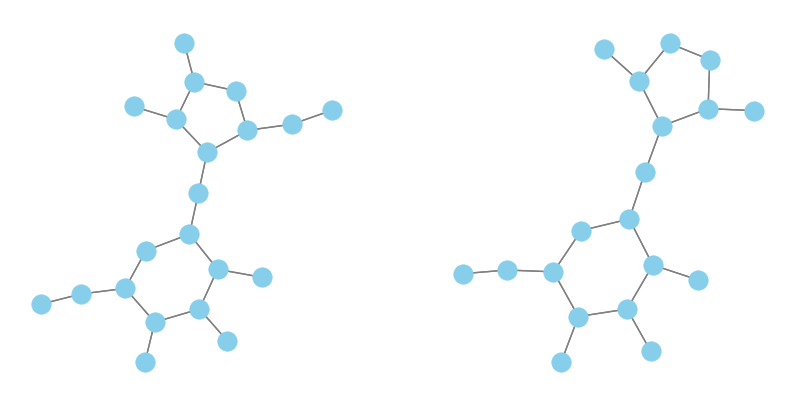

In [63]:
plt.figure(figsize=(10, 5))

sample = train_dataset[4242]

for descr in sample.description:
    print(descr)

plt.subplot(1, 2, 1)
edges = sample.edge_index_original
G = nx.DiGraph()
for i in range(len(edges[0])):
    G.add_edge(int(edges[0][i]), int(edges[1][i]))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=False, font_size=8, node_color='skyblue', node_size=200, edge_color='gray', linewidths=0.3, arrows=False)

plt.subplot(1, 2, 2)
edges = sample.edge_index_augment
G = nx.DiGraph()
for i in range(len(edges[0])):
    G.add_edge(int(edges[0][i]), int(edges[1][i]))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=False, font_size=8, node_color='skyblue', node_size=200, edge_color='gray', linewidths=0.3, arrows=False)
plt.show()

In [10]:
from augment import RWSample, UniformSample

def get_graphs():
    gt = np.load("../data/token_embedding_dict.npy", allow_pickle=True)[()]
    dataset = AllGraphDataset(root="../data/", gt=gt)
    augmented_dataset = AugmentGraphDataset(dataset, transforms=[RWSample(), UniformSample()])
    return augmented_dataset

In [11]:
graph_dataset = get_graphs()

In [32]:
graph_dataset[4]

PairData(edge_index_anchor=[2, 64], x_anchor=[29, 300], edge_index_pos=[2, 50], x_pos=[23, 300])

(Data(x=[29, 300], edge_index=[2, 64]), Data(x=[26, 300], edge_index=[2, 56]))

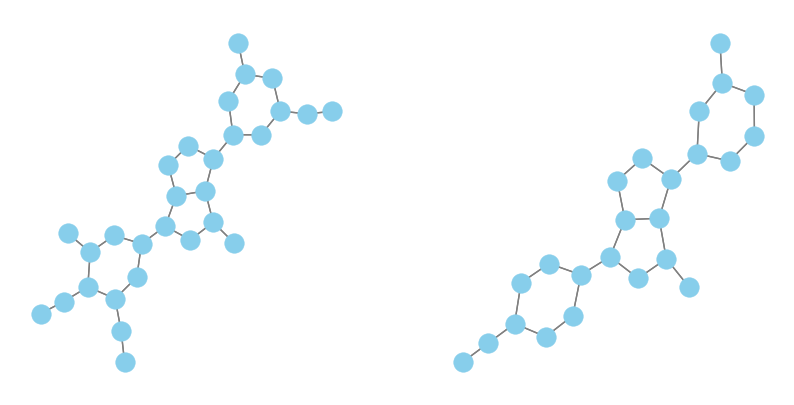

In [56]:
plt.figure(figsize=(10, 5))

sample = graph_dataset[4]
original_graph = Data(
    x=sample.x_anchor,
    edge_index=sample.edge_index_anchor,
)
augment_graph = Data(
    x=sample.x_pos,
    edge_index=sample.edge_index_pos,
)
original_graph, augment_graph

plt.subplot(1, 2, 1)

edges = original_graph.edge_index
G = nx.DiGraph()
for i in range(len(edges[0])):
    G.add_edge(int(edges[0][i]), int(edges[1][i]))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=False, font_size=8, node_color='skyblue', node_size=200, edge_color='gray', linewidths=0.3, arrows=False)

plt.subplot(1, 2, 2)

edges = augment_graph.edge_index
G = nx.DiGraph()
for i in range(len(edges[0])):
    G.add_edge(int(edges[0][i]), int(edges[1][i]))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=False, font_size=8, node_color='skyblue', node_size=200, edge_color='gray', linewidths=0.3, arrows=False)

plt.show()

tensor([[ 0,  1,  1,  2,  1,  3,  3,  4,  4,  5,  5,  6,  6,  7,  6,  8,  5,  9,
          9, 10, 10, 11, 11, 12, 11, 13, 10, 14, 14,  3],
        [ 1,  0,  2,  1,  3,  1,  4,  3,  5,  4,  6,  5,  7,  6,  8,  6,  9,  5,
         10,  9, 11, 10, 12, 11, 13, 11, 14, 10,  3, 14]])
tensor([[ 0,  1,  1,  2,  1,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,
          9, 10, 10, 11, 11, 12, 11, 13],
        [ 1,  0,  2,  1,  3,  1,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,  8,
         10,  9, 11, 10, 12, 11, 13, 11]])
tensor([[ 0,  1,  1,  2,  1,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,
          9, 10,  9, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18,
         18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 23, 25],
        [ 1,  0,  2,  1,  3,  1,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,  8,
         10,  9, 11,  9, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16, 18, 17,
         19, 18, 20, 19, 21, 20, 22, 21, 23, 22, 24, 23, 25, 23]])
tensor([[ 0,  1, 

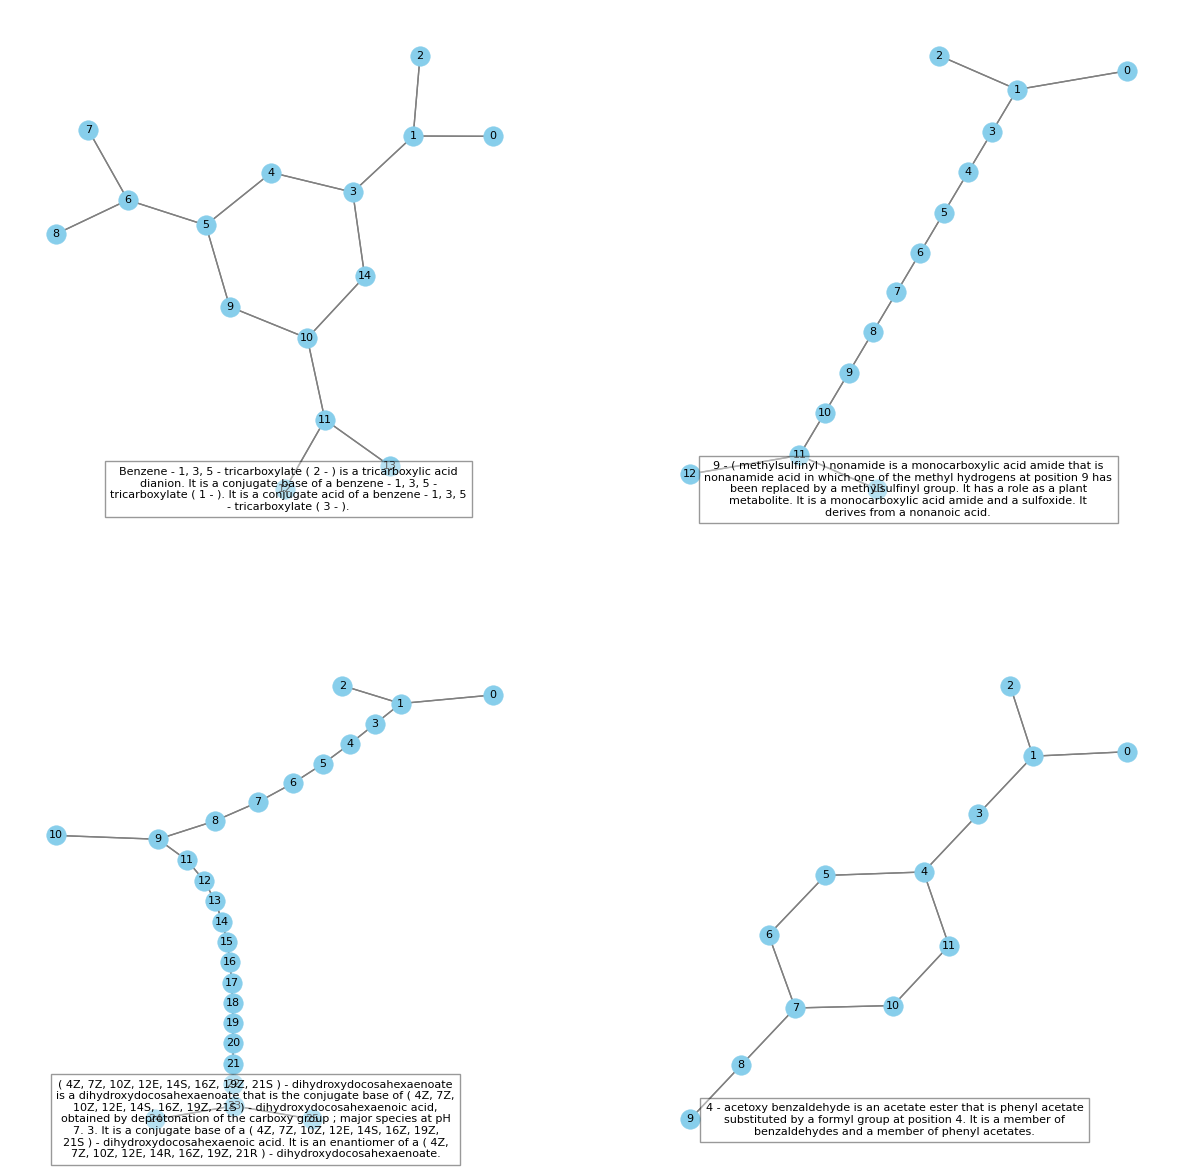

In [34]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
show_sample(train_dataset[452])
plt.subplot(2, 2, 2)
show_sample(train_dataset[785])
plt.subplot(2, 2, 3)
show_sample(train_dataset[4542])
plt.subplot(2, 2, 4)
show_sample(train_dataset[4277])

In [1]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext')

No sentence-transformers model found with name C:\Users\Antoine/.cache\torch\sentence_transformers\microsoft_BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext. Creating a new one with MEAN pooling.


In [ ]:
decoded_input = tokenizer.batch_decode(train_dataset[41].input_ids, skip_special_tokens=True)[0]
print(decoded_input)
embedding = model.encode(
    decoded_input
)
print(embedding.shape)

In [4]:
import pandas as pd

In [13]:
train_ds = pd.read_csv("./data/train.tsv", sep="\t")
val_ds = pd.read_csv("./data/val.tsv", sep="\t")

# Read data/test_text.txt into a list of strings
with open("./data/test_text.txt", "r") as f:
    test_text = f.readlines()

test_text = [text.strip() for text in test_text]

In [14]:
ds = train_ds.iloc[:, 1].tolist() + val_ds.iloc[:, 1].tolist() + test_text

In [2]:
# Save to pandas dataframe
df = pd.DataFrame(ds, columns=["text"])
df.to_csv("./data/text.csv", index=False)

NameError: name 'pd' is not defined

In [10]:
# Truncate the text to 512 tokens and add overflow to new rows
df = pd.read_csv("./data/text.csv")

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext')

def preprocess(samples):
    batch_size = 64

    tokenized = []
    for i in range(0, len(samples), batch_size):
        tokenized.append(tokenizer(samples["text"][i:i+batch_size].tolist(), truncation=True, max_length=256, return_overflowing_tokens=True))
    return tokenized

tokenized = preprocess(df)

In [18]:
df = pd.DataFrame(columns=["text", "input_ids", "attention_mask"])
for i in range(len(tokenized)):
    # df = df.append(pd.DataFrame({
    #     "text": tokenized[i]["input_ids"],
    #     "input_ids": tokenized[i]["input_ids"],
    #     "attention_mask": tokenized[i]["attention_mask"],
    # }))
    # Change append to concat
    df = pd.concat([df, pd.DataFrame({
        "text": tokenized[i]["input_ids"],
        "input_ids": tokenized[i]["input_ids"],
        "attention_mask": tokenized[i]["attention_mask"],
    })])
df

,text,input_ids,attention_mask
0,"[2, 22, 17, 4118, 25238, 1037, 17, 22, 17, 163...","[2, 22, 17, 4118, 25238, 1037, 17, 22, 17, 163...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"[2, 19406, 1935, 2687, 1977, 1925, 4595, 16, 1...","[2, 19406, 1935, 2687, 1977, 1925, 4595, 16, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"[2, 2136, 17, 2127, 17, 24, 17, 18588, 28038, ...","[2, 2136, 17, 2127, 17, 24, 17, 18588, 28038, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"[2, 7843, 22, 17, 20990, 2928, 9286, 2010, 197...","[2, 7843, 22, 17, 20990, 2928, 9286, 2010, 197...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"[2, 10534, 5405, 2053, 12, 21, 15, 13, 1977, 1...","[2, 10534, 5405, 2053, 12, 21, 15, 13, 1977, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...
43,"[2, 12, 17659, 13, 17, 24321, 11800, 11123, 19...","[2, 12, 17659, 13, 17, 24321, 11800, 11123, 19...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
44,"[2, 12, 24, 17, 20990, 22467, 2199, 13, 29141,...","[2, 12, 24, 17, 20990, 22467, 2199, 13, 29141,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
45,"[2, 8298, 4151, 2057, 1977, 43, 3421, 5482, 19...","[2, 8298, 4151, 2057, 1977, 43, 3421, 5482, 19...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
46,"[2, 54, 17, 13489, 5482, 12, 21, 15, 13, 1977,...","[2, 54, 17, 13489, 5482, 12, 21, 15, 13, 1977,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [16]:
df.to_csv("./data/text_tokenized.csv", index=False)

,text,input_ids,attention_mask
0,"[2, 22, 17, 4118, 25238, 1037, 17, 22, 17, 163...","[2, 22, 17, 4118, 25238, 1037, 17, 22, 17, 163...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"[2, 19406, 1935, 2687, 1977, 1925, 4595, 16, 1...","[2, 19406, 1935, 2687, 1977, 1925, 4595, 16, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"[2, 2136, 17, 2127, 17, 24, 17, 18588, 28038, ...","[2, 2136, 17, 2127, 17, 24, 17, 18588, 28038, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"[2, 7843, 22, 17, 20990, 2928, 9286, 2010, 197...","[2, 7843, 22, 17, 20990, 2928, 9286, 2010, 197...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"[2, 10534, 5405, 2053, 12, 21, 15, 13, 1977, 1...","[2, 10534, 5405, 2053, 12, 21, 15, 13, 1977, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...
43,"[2, 12, 17659, 13, 17, 24321, 11800, 11123, 19...","[2, 12, 17659, 13, 17, 24321, 11800, 11123, 19...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
44,"[2, 12, 24, 17, 20990, 22467, 2199, 13, 29141,...","[2, 12, 24, 17, 20990, 22467, 2199, 13, 29141,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
45,"[2, 8298, 4151, 2057, 1977, 43, 3421, 5482, 19...","[2, 8298, 4151, 2057, 1977, 43, 3421, 5482, 19...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
46,"[2, 54, 17, 13489, 5482, 12, 21, 15, 13, 1977,...","[2, 54, 17, 13489, 5482, 12, 21, 15, 13, 1977,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
